In [17]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Load the datasets
train_path = "train.csv"
test_path = "test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Separate features and target variable
X = train_df.drop(columns=['Id', 'label'])
y = train_df['label']

# Identify categorical and numerical features
categorical_features = [col for col in X.columns if 'categorical' in col]
numerical_features = [col for col in X.columns if 'numerical' in col]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
X_train_num_df = (X_train[numerical_features] - X_train[numerical_features].mean()) / X_train[numerical_features].std()
X_val_num_df = (X_val[numerical_features] - X_train[numerical_features].mean()) / X_train[numerical_features].std()
X_test_num_df = (test_df[numerical_features] - X_train[numerical_features].mean()) / X_train[numerical_features].std()

# One-hot encode categorical features
X_train_cat_df = pd.get_dummies(X_train[categorical_features], drop_first=True)
X_val_cat_df = pd.get_dummies(X_val[categorical_features], drop_first=True)
X_test_cat_df = pd.get_dummies(test_df[categorical_features], drop_first=True)

# Align categorical features across datasets
X_train_cat_df, X_val_cat_df = X_train_cat_df.align(X_val_cat_df, join="left", axis=1, fill_value=0)
X_train_cat_df, X_test_cat_df = X_train_cat_df.align(X_test_cat_df, join="left", axis=1, fill_value=0)

# Concatenate numerical and categorical features
X_train_processed = pd.concat([X_train_num_df, X_train_cat_df], axis=1)
X_val_processed = pd.concat([X_val_num_df, X_val_cat_df], axis=1)
X_test_processed = pd.concat([X_test_num_df, X_test_cat_df], axis=1)

# Train logistic regression model
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train_processed, y_train)

# Predict probabilities for validation set
y_val_probs = log_reg.predict_proba(X_val_processed)[:, 1]

# Compute AUC score
auc_score = roc_auc_score(y_val, y_val_probs)
print(f"Validation AUC Score: {auc_score:.4f}")

# Predict probabilities for test set
test_probabilities = log_reg.predict_proba(X_test_processed)[:, 1]

# Save test predictions
test_results = pd.DataFrame({
    'Id': test_df['Id'],
    'label': test_probabilities
})
test_results.to_csv("test_predictions.csv", index=False)

print("Test probabilities saved to test_predictions.csv")

Validation AUC Score: 0.8505
Test probabilities saved to test_predictions.csv


In [22]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# 1. Load data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# 2. Split features and target
X = train_df.drop(columns=["Id", "label"])
y = train_df["label"]

# 3. Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# 5. Evaluate on validation set
val_probs = rf_model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_probs)
print(f"Validation AUC: {val_auc:.4f}")

# 6. Predict on test set
X_test = test_df.drop(columns=["Id"])
test_probs = rf_model.predict_proba(X_test)[:, 1]

# 7. Create submission file
submission_df = pd.DataFrame({
    "Id": test_df["Id"],
    "proba": test_probs
})

submission_df.to_csv("final_submission.csv", index=False)
print("Submission file 'final_submission.csv' created.")


Validation AUC: 0.9403
Submission file 'final_submission.csv' created.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


(np.float64(0.8445183463216349),
 np.float64(0.8504889129947135),
 {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'})

Epoch 50/300, Train Loss: 0.4838, Val Loss: 0.4821, Train AUC: 0.8230, Val AUC: 0.8267
Epoch 100/300, Train Loss: 0.4665, Val Loss: 0.4641, Train AUC: 0.8316, Val AUC: 0.8359
Epoch 150/300, Train Loss: 0.4594, Val Loss: 0.4566, Train AUC: 0.8361, Val AUC: 0.8408
Epoch 200/300, Train Loss: 0.4555, Val Loss: 0.4524, Train AUC: 0.8387, Val AUC: 0.8436
Epoch 250/300, Train Loss: 0.4530, Val Loss: 0.4499, Train AUC: 0.8403, Val AUC: 0.8453
Epoch 300/300, Train Loss: 0.4514, Val Loss: 0.4483, Train AUC: 0.8413, Val AUC: 0.8464


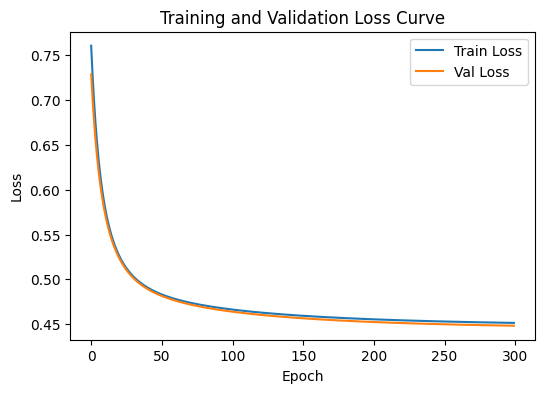

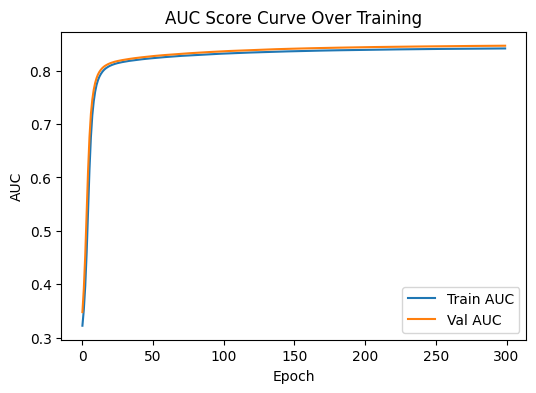

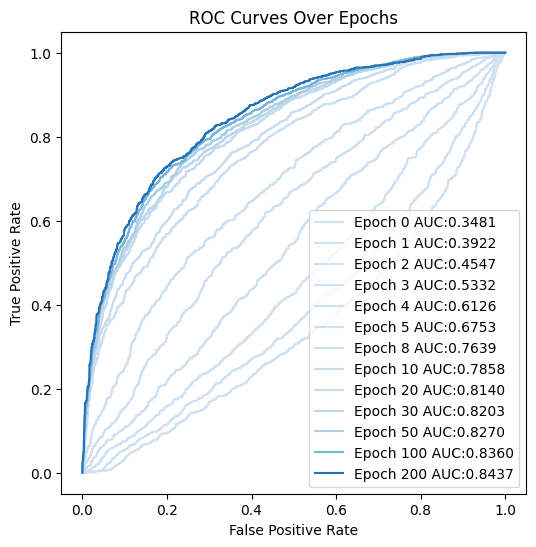

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Load the datasets
train_path = "train.csv"
test_path = "test.csv"
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Separate features and target variable
X = train_df.drop(columns=['Id', 'label'])
y = train_df['label'].values

# Identify categorical and numerical features
categorical_features = [col for col in X.columns if 'categorical' in col]
numerical_features = [col for col in X.columns if 'numerical' in col]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
X_train_num_df = (X_train[numerical_features] - X_train[numerical_features].mean()) / X_train[numerical_features].std()
X_val_num_df = (X_val[numerical_features] - X_train[numerical_features].mean()) / X_train[numerical_features].std()
X_test_num_df = (test_df[numerical_features] - X_train[numerical_features].mean()) / X_train[numerical_features].std()

# One-hot encode categorical features
X_train_cat_df = pd.get_dummies(X_train[categorical_features], drop_first=True)
X_val_cat_df = pd.get_dummies(X_val[categorical_features], drop_first=True)
X_test_cat_df = pd.get_dummies(test_df[categorical_features], drop_first=True)

# Align categorical features across datasets
X_train_cat_df, X_val_cat_df = X_train_cat_df.align(X_val_cat_df, join="left", axis=1, fill_value=0)
X_train_cat_df, X_test_cat_df = X_train_cat_df.align(X_test_cat_df, join="left", axis=1, fill_value=0)

# Concatenate numerical and categorical features
X_train_processed = pd.concat([X_train_num_df, X_train_cat_df], axis=1)
X_val_processed = pd.concat([X_val_num_df, X_val_cat_df], axis=1)
X_test_processed = pd.concat([X_test_num_df, X_test_cat_df], axis=1)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_processed.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# Define a simple neural network
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize model, loss function, and optimizer
input_dim = X_train_processed.shape[1]
model = LogisticRegression(input_dim)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.2)

# Training loop
num_epochs = 300
train_losses = []
val_losses = []
train_auc_scores = []
val_auc_scores = []
roc_curves = []

for epoch in range(num_epochs):
    # Forward pass
    y_train_pred = model(X_train_tensor)
    loss = criterion(y_train_pred, y_train_tensor)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Compute AUC for training set
    y_train_pred_probs = y_train_pred.detach().numpy()
    train_auc_score = roc_auc_score(y_train, y_train_pred_probs)

    # Validation loss and AUC calculation
    with torch.no_grad():
        y_val_pred = model(X_val_tensor)
        val_loss = criterion(y_val_pred, y_val_tensor)

        y_val_pred_probs = y_val_pred.numpy()
        val_auc_score = roc_auc_score(y_val, y_val_pred_probs)
        fpr, tpr, _ = roc_curve(y_val, y_val_pred_probs)
        roc_curves.append((fpr, tpr, val_auc_score, epoch))

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_auc_scores.append(train_auc_score)
    val_auc_scores.append(val_auc_score)

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Train AUC: {train_auc_score:.4f}, Val AUC: {val_auc_score:.4f}")


# Plot Loss curves over epochs
plt.figure(figsize=(6, 4))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()


# Plot AUC values over epochs for training and validation sets
plt.figure(figsize=(6, 4))
plt.plot(range(num_epochs), train_auc_scores, label='Train AUC')
plt.plot(range(num_epochs), val_auc_scores, label='Val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC Score Curve Over Training')
plt.legend()
plt.show()



# Plot multiple AUC curves with different intensities
plt.figure(figsize=(6, 6))


color = cm.Blues(np.linspace(0.2, 1, len(roc_curves)))
for i, (fpr, tpr, auc_score, epoch) in enumerate(roc_curves):
    # if (epoch+1) % 30 == 0 or epoch == num_epochs-1 or epoch==0:
    if epoch in [0, 1, 2, 3, 4, 5, 8, 10, 20, 30, 50, 100, 200, 300]:
        plt.plot(fpr, tpr, label=f'Epoch {epoch} AUC:{auc_score:.4f}', color=color[i])


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Over Epochs')
plt.legend()
plt.show()

# print("Training complete. Multiple AUC curves plotted with varying intensity.")
# print("Training complete. AUC curves plotted.")


Train AUC: 0.9991, Validation AUC: 0.9393


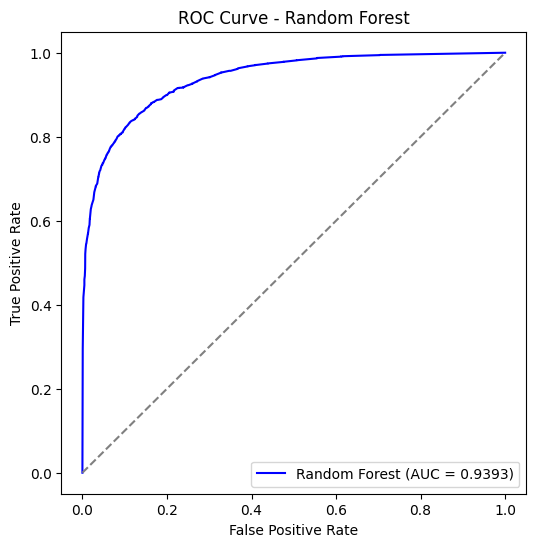

Submission file 'rf_submission.csv' created.


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
import matplotlib.cm as cm

# Load the datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Separate features and target variable
X = train_df.drop(columns=['Id', 'label'])
y = train_df['label'].values

# Identify categorical and numerical features
categorical_features = [col for col in X.columns if 'categorical' in col]
numerical_features = [col for col in X.columns if 'numerical' in col]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
X_train_num_df = (X_train[numerical_features] - X_train[numerical_features].mean()) / X_train[numerical_features].std()
X_val_num_df = (X_val[numerical_features] - X_train[numerical_features].mean()) / X_train[numerical_features].std()
X_test_num_df = (test_df[numerical_features] - X_train[numerical_features].mean()) / X_train[numerical_features].std()

# One-hot encode categorical features
X_train_cat_df = pd.get_dummies(X_train[categorical_features], drop_first=True)
X_val_cat_df = pd.get_dummies(X_val[categorical_features], drop_first=True)
X_test_cat_df = pd.get_dummies(test_df[categorical_features], drop_first=True)

# Align categorical features across datasets
X_train_cat_df, X_val_cat_df = X_train_cat_df.align(X_val_cat_df, join="left", axis=1, fill_value=0)
X_train_cat_df, X_test_cat_df = X_train_cat_df.align(X_test_cat_df, join="left", axis=1, fill_value=0)

# Concatenate numerical and categorical features
X_train_processed = pd.concat([X_train_num_df, X_train_cat_df], axis=1)
X_val_processed = pd.concat([X_val_num_df, X_val_cat_df], axis=1)
X_test_processed = pd.concat([X_test_num_df, X_test_cat_df], axis=1)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_processed, y_train)

# Predict probabilities for train and val sets
y_train_probs = rf_model.predict_proba(X_train_processed)[:, 1]
y_val_probs = rf_model.predict_proba(X_val_processed)[:, 1]

# Compute AUC scores
train_auc = roc_auc_score(y_train, y_train_probs)
val_auc = roc_auc_score(y_val, y_val_probs)
print(f"Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

# Plot ROC curve for validation set
fpr, tpr, _ = roc_curve(y_val, y_val_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {val_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()

